In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.impute import KNNImputer
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import mean_squared_error

In [3]:
# I used Google Colab to write/run my code, so the reading of the csv file might need to be adjusted if the code is not run in Google Colab
df = pd.read_csv('/content/obp.csv')
print("Shape:", df.shape)
df

Shape: (572, 15)


,Name,playerid,birth_date,PA_21,OBP_21,PA_20,OBP_20,PA_19,OBP_19,PA_18,OBP_18,PA_17,OBP_17,PA_16,OBP_16
0,Drew Butera,3411,8/9/1983,36,0.091,43.0,0.190,49.0,0.229,182.0,0.264,177.0,0.284,133.0,0.328
1,Skye Bolt,17723,1/15/1994,60,0.103,NaN,NaN,11.0,0.182,NaN,NaN,NaN,NaN,NaN,NaN
2,Curtis Terry,18881,10/6/1996,48,0.146,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,Scott Schebler,12225,10/6/1990,34,0.147,1.0,0.000,95.0,0.253,430.0,0.337,531.0,0.307,282.0,0.330
4,Albert Almora Jr.,14109,4/16/1994,54,0.148,34.0,0.265,363.0,0.271,479.0,0.323,323.0,0.338,117.0,0.308
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
567,Yasmani Grandal,11368,11/8/1988,375,0.420,194.0,0.351,632.0,0.380,518.0,0.349,482.0,0.308,457.0,0.339
568,Chris Owings,10030,8/12/1991,50,0.420,44.0,0.318,196.0,0.209,309.0,0.272,386.0,0.299,466.0,0.315
569,Bryce Harper,11579,10/16/1992,599,0.429,244.0,0.420,682.0,0.372,695.0,0.393,492.0,0.413,627.0,0.373
570,Juan Soto,20123,10/25/1998,654,0.465,196.0,0.490,659.0,0.401,494.0,0.406,NaN,NaN,NaN,NaN


In [ ]:
print("Missing Values of each variable:")
print(df.isnull().sum()) # total missing values in each var
print("Total Missing values in dataset:")
print(df.isnull().sum().sum()) # total missing values in dataset

Missing Values of each variable:
Name            0
playerid        0
birth_date      0
PA_21           0
OBP_21          0
PA_20         106
OBP_20        106
PA_19         135
OBP_19        135
PA_18         213
OBP_18        213
PA_17         274
OBP_17        274
PA_16         325
OBP_16        325
dtype: int64
Total Missing values in dataset:
2106


  Season  Missing_Stats
5     16            325
4     17            274
3     18            213
2     19            135
1     20            106
0     21              0


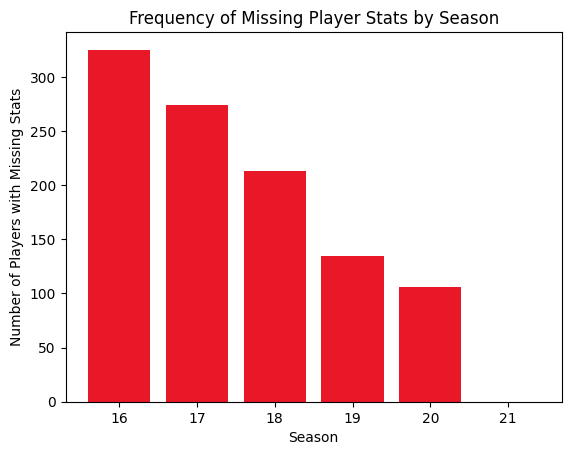

In [ ]:
# filtering out the 'PA_' columns that correspond to the player's plate appearances each year
PA_columns = [col for col in df.columns if 'PA_' in col] # this line of code was written with the help of ChatGPT

# counting missing values for 'PA_' columns (representing each season)
# this is because the number of missing values for PA_## is the same as the number of missing values for OBP_##
missing_stats = df[PA_columns].isnull().sum()

# creating a DataFrame showing the number of missing stats per season
missing_stats_by_season = pd.DataFrame({
    'Season': [col.split('_')[1] for col in missing_stats.index],     # this line of code was written with the help of ChatGPT
    'Missing_Stats': missing_stats.values
})

# sort in ascending order and display the missing stats by season
missing_stats_by_season = missing_stats_by_season.sort_values('Season')
print(missing_stats_by_season)

# visualizing using a bar chart
plt.bar(missing_stats_by_season['Season'], missing_stats_by_season['Missing_Stats'], color='#E81828') # Phillies' red!
plt.xlabel('Season')
plt.ylabel('Number of Players with Missing Stats')
plt.title('Frequency of Missing Player Stats by Season')
plt.show()

In [ ]:
## creating a new column called birth_year, which displays which year the player was born
df['birth_date'] = pd.to_datetime(df['birth_date'], format='%m/%d/%Y')
df['birth_year'] = df['birth_date'].dt.year

## creating a new column called Age_21, which tells us the age of the player during the 2021 season
df['Age_21'] = 2021 - df['birth_year']    # this is accomplished by subtracting 2021 - birth_year

# dropping playerid, birth_date, and birth_year columns since they are no longer needed
df = df.drop(['playerid','birth_date','birth_year'], axis = 1)
df.head(4)

,Name,PA_21,OBP_21,PA_20,OBP_20,PA_19,OBP_19,PA_18,OBP_18,PA_17,OBP_17,PA_16,OBP_16,Age_21
0,Trayce Thompson,35,0.400,NaN,NaN,NaN,NaN,137.0,0.162,55.0,0.218,262.0,0.302,30
1,Mike Trout,146,0.466,241.0,0.390,600.0,0.438,608.0,0.460,507.0,0.442,681.0,0.441,30
2,Bryce Harper,599,0.429,244.0,0.420,682.0,0.372,695.0,0.393,492.0,0.413,627.0,0.373,29
3,Chris Owings,50,0.420,44.0,0.318,196.0,0.209,309.0,0.272,386.0,0.299,466.0,0.315,30


count    572.000000
mean       0.305063
std        0.049787
min        0.091000
25%        0.277000
50%        0.310000
75%        0.337000
max        0.466000
Name: OBP_21, dtype: float64


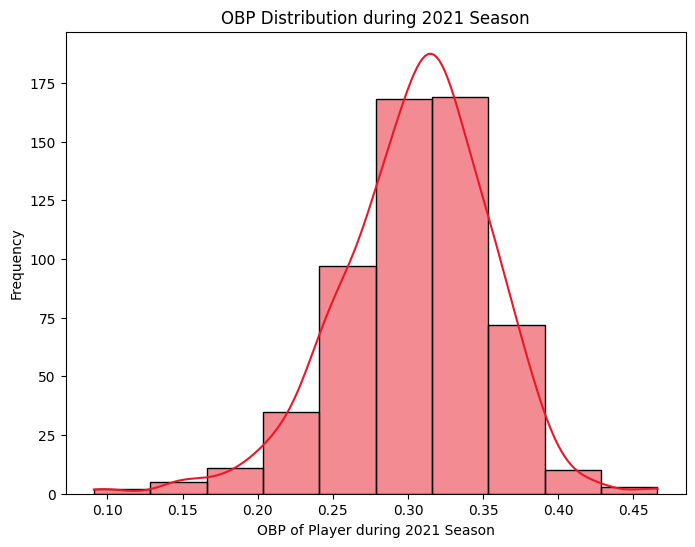

In [ ]:
# descriptive statistics for the OBPs during the 2021 season
print(df['OBP_21'].describe())

# visualizing the distribution of OBP during the 2021 season using a histogram
plt.figure(figsize=(8,6))
sns.histplot(df['OBP_21'], bins=10, kde=True, color='#E81828')
plt.title('OBP Distribution during 2021 Season')
plt.xlabel('OBP of Player during 2021 Season')
plt.ylabel('Frequency')
plt.show()

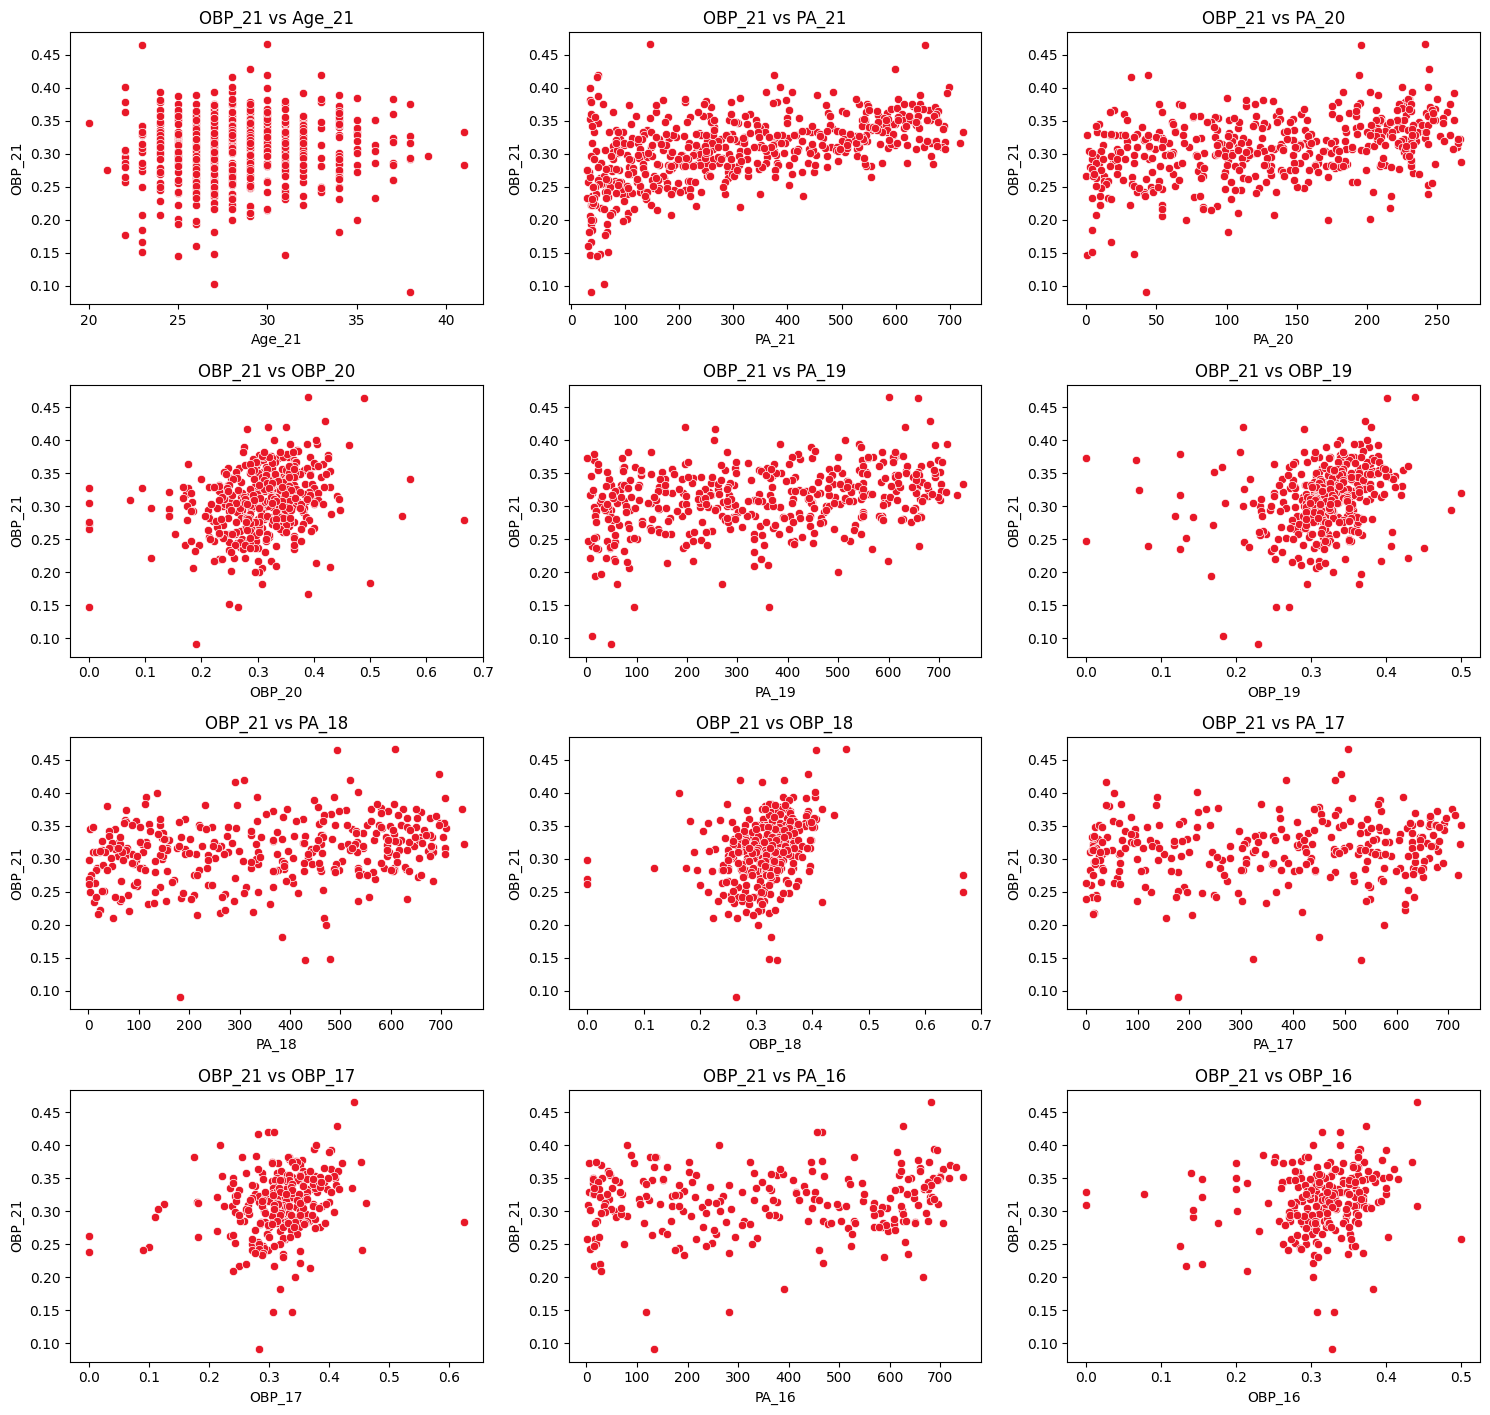

In [ ]:
# see the relationship between each variable and OBP_21
# list of variables to compare with OBP_21
x_variables = ['Age_21','PA_21','PA_20','OBP_20','PA_19','OBP_19','PA_18','OBP_18','PA_17','OBP_17','PA_16','OBP_16']
y_variable = 'OBP_21'

# Create subplots
fig, axes = plt.subplots(nrows=4, ncols=3, figsize=(15, 15))

# flattening the axes array for easy iteration
axes = axes.flatten()

# looping through x_variables and plot them against y_variable (OBP_21)
for i, var in enumerate(x_variables):     # help with this code was gotten from ChatGPT
    sns.scatterplot(x=df[var], y=df[y_variable], ax=axes[i], color='#E81828')
    axes[i].set_title(f'{y_variable} vs {var}')
    axes[i].set_xlabel(var)
    axes[i].set_ylabel(y_variable)

plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()

In [ ]:
## imputing values using k nearest neighbors (5)
imputer = KNNImputer(n_neighbors=5)
missing_vars = ['Age_21','PA_21','PA_20','OBP_20','PA_19','OBP_19','PA_18','OBP_18','PA_17','OBP_17','PA_16','OBP_16']
impute = pd.DataFrame(imputer.fit_transform(df[missing_vars]),columns = missing_vars)
df_imputed = pd.concat([df[['Name', 'OBP_21']], impute], axis=1)
df_imputed
# referenced https://stackoverflow.com/questions/67525333/how-to-fill-missing-value-with-knn-in-python

,Name,OBP_21,Age_21,PA_21,PA_20,OBP_20,PA_19,OBP_19,PA_18,OBP_18,PA_17,OBP_17,PA_16,OBP_16
0,Trayce Thompson,0.400,30.0,35.0,34.2,0.2588,76.0,0.2848,137.0,0.1620,55.0,0.2180,262.0,0.3020
1,Mike Trout,0.466,30.0,146.0,241.0,0.3900,600.0,0.4380,608.0,0.4600,507.0,0.4420,681.0,0.4410
2,Bryce Harper,0.429,29.0,599.0,244.0,0.4200,682.0,0.3720,695.0,0.3930,492.0,0.4130,627.0,0.3730
3,Chris Owings,0.420,30.0,50.0,44.0,0.3180,196.0,0.2090,309.0,0.2720,386.0,0.2990,466.0,0.3150
4,Nick Fortes,0.353,25.0,34.0,31.4,0.3340,97.6,0.2716,153.6,0.2680,201.0,0.2672,185.8,0.3064
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
567,Greg Deichmann,0.161,26.0,31.0,50.6,0.2300,210.6,0.2682,265.2,0.2872,235.6,0.2736,180.4,0.3422
568,Cameron Maybin,0.182,34.0,33.0,101.0,0.3070,269.0,0.3640,384.0,0.3260,450.0,0.3180,391.0,0.3830
569,Curtis Terry,0.146,25.0,48.0,35.8,0.2858,186.2,0.3058,261.2,0.2988,152.8,0.2338,225.6,0.2680
570,Skye Bolt,0.103,27.0,60.0,19.8,0.2452,11.0,0.1820,92.2,0.3082,134.6,0.2534,232.0,0.3042


In [ ]:
# creating train/test split
x = df_imputed.drop(columns=['OBP_21'])
y = df_imputed['OBP_21']
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=1234)

names_test = x_test['Name']
x_train = x_train.drop(columns=['Name'])
x_test = x_test.drop(columns=['Name'])

In [ ]:
# initalize the Random Forest model
random_forest_model = RandomForestRegressor(n_estimators= 100, max_depth= None, min_samples_split= 5,min_samples_leaf=2,max_features="sqrt", oob_score=True, random_state= 1234)
# referenced https://www.comet.com/site/blog/random-forest-regression-in-python-using-scikit-learn/

# performing cross-validation for random forest
cv_scores = cross_val_score(random_forest_model, x_train, y_train, cv=10, scoring='neg_mean_squared_error', error_score='raise')
cv_rmse_scores = np.sqrt(-cv_scores)
print("Cross-Validation RMSE: ", cv_rmse_scores.mean())
# referenced https://stackoverflow.com/questions/21443865/scikit-learn-cross-validation-negative-values-with-mean-squared-error

# fit the model on the entire training set
random_forest_model.fit(x_train, y_train)

# use the model to predict on the test set
y_test_pred = random_forest_model.predict(x_test)
test_rmse = np.sqrt(mean_squared_error(y_test, y_test_pred))
print("Test RMSE: ", test_rmse)

# creating a comparison DataFrame including the real value, the predicted value, and the difference between the two
df_comp = pd.DataFrame({'Name': names_test,'True Values': y_test,'Predicted Values': y_test_pred})
df_comp['Difference'] = df_comp['True Values'] - df_comp['Predicted Values']

df_comp

Cross-Validation RMSE:  0.043695892498509456
Test RMSE:  0.03702451890024986


,Name,True Values,Predicted Values,Difference
534,Sheldon Neuse,0.182,0.252817,-0.070817
166,Akil Baddoo,0.330,0.319553,0.010447
451,Seby Zavala,0.240,0.273159,-0.033159
66,J.D. Davis,0.384,0.305937,0.078063
220,Corey Dickerson,0.326,0.308724,0.017276
...,...,...,...,...
27,Tyler O'Neill,0.352,0.304820,0.047180
92,Michael Brantley,0.362,0.349169,0.012831
171,Ian Happ,0.323,0.328162,-0.005162
410,Roman Quinn,0.306,0.264390,0.041610


In [ ]:
# initalize the Gradient Boosting model
gradient_boosting_model = GradientBoostingRegressor(n_estimators=100, max_depth=2, min_samples_split=5, min_samples_leaf=10, learning_rate=0.05, random_state=1234)
# referenced https://scikit-learn.org/dev/modules/generated/sklearn.ensemble.GradientBoostingRegressor.html

# performing cross-validation for random forest
cv_scores = cross_val_score(gradient_boosting_model, x_train, y_train, cv=10, scoring='neg_mean_squared_error', error_score='raise')
cv_rmse_scores = np.sqrt(-cv_scores)
print("Cross-Validation RMSE: ", cv_rmse_scores.mean())
# referenced https://stackoverflow.com/questions/21443865/scikit-learn-cross-validation-negative-values-with-mean-squared-error

# fit the model on the entire training set
gradient_boosting_model.fit(x_train, y_train)

# use the model to predict on the test set
y_test_pred = gradient_boosting_model.predict(x_test)
test_rmse = np.sqrt(mean_squared_error(y_test, y_test_pred))
print("Test RMSE: ", test_rmse)

# creating a comparison DataFrame including the real value, the predicted value, and the difference between the two
df_comp2 = pd.DataFrame({'Name': names_test,'True Values': y_test,'Predicted Values': y_test_pred})
df_comp2['Difference'] = df_comp2['True Values'] - df_comp2['Predicted Values']

df_comp2

Cross-Validation RMSE:  0.0419361950141227
Test RMSE:  0.03827906618861794


,Name,True Values,Predicted Values,Difference
534,Sheldon Neuse,0.182,0.244508,-0.062508
166,Akil Baddoo,0.330,0.319581,0.010419
451,Seby Zavala,0.240,0.274614,-0.034614
66,J.D. Davis,0.384,0.300417,0.083583
220,Corey Dickerson,0.326,0.313118,0.012882
...,...,...,...,...
27,Tyler O'Neill,0.352,0.312116,0.039884
92,Michael Brantley,0.362,0.348770,0.013230
171,Ian Happ,0.323,0.336551,-0.013551
410,Roman Quinn,0.306,0.256470,0.049530
